In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os; sys.path.append('../../')
import Baryonification as bfn
import pyccl as ccl

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.26, Omega_b = 0.04, h = 0.7, sigma8 = 0.8, n_s = 0.96, matter_power_spectrum='linear')

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar = np.load('./default_config.npy', allow_pickle = True)[()]
bpar['cutoff'] = 1_000_000 #Setting cutoff to crazy high values so there is no cutoff in profiles. Just for now.

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
#DMO and DMB models
DMO = bfn.Profiles.DarkMatterOnly(**bpar)
DMB = bfn.Profiles.DarkMatterBaryon(**bpar)

#Regular displacement model
Displacement = bfn.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Displacement.setup_interpolator(z_min = 0, z_max = 5, N_samples_z = 2, z_linear_sampling = True, 
                                R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True)

#Regular displacement model
Displacement_withc200c = bfn.Profiles.Baryonification3D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Displacement_withc200c.setup_interpolator(z_min = 0, z_max = 5, N_samples_z = 2, z_linear_sampling = True, 
                                          R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True,
                                          other_params = {'cdelta' : np.linspace(1, 100, 10)})

#Projected displacement, with the projection scale as a free parameter
Displacement2D = bfn.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
Displacement2D.setup_interpolator(z_min = 0, z_max = 5, N_samples_z = 2, z_linear_sampling = True, 
                                  R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True,
                                  other_params = {'proj_cutoff' : np.linspace(60, 1000, 10)});

Building Table: 100%|███████████████████████████████████████████████████████████████████| 20/20 [01:27<00:00,  4.37s/it]


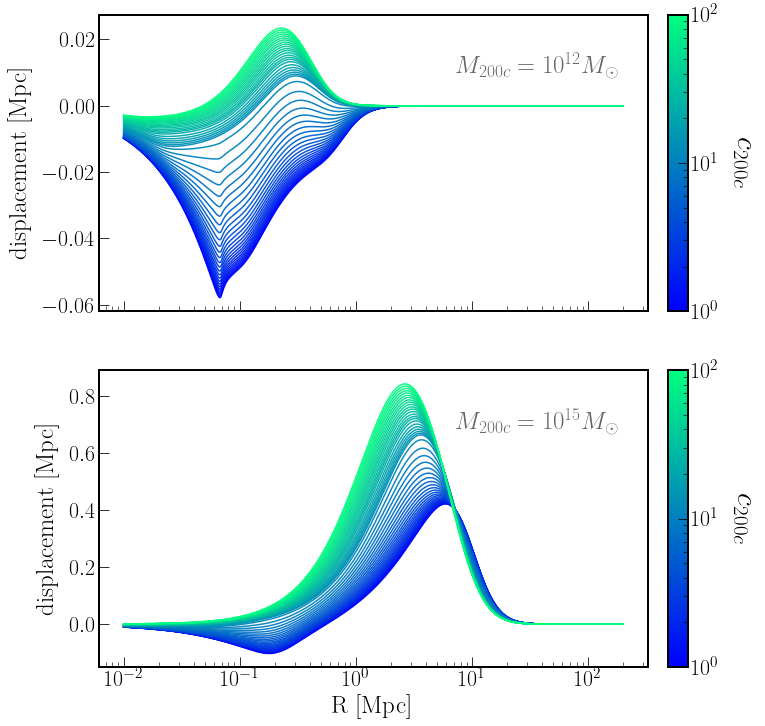

In [4]:
import matplotlib as mpl
fig, ax = plt.subplots(2, 1, figsize = (12, 12), sharex = True)
plt.xscale('log')

M = [1e12, 1e15]

#Loop over two masses
for i in range(len(M)):
    R = np.geomspace(1e-2, 200, 1000)
    a = 1
    
    #Loop over concentration values
    for c in np.geomspace(1, 100, 50):
        ax.flat[i].plot(R, Displacement_withc200c.displacement(R*a, M[i], a, cdelta = c), 
                        color = plt.get_cmap('winter')(np.log10(c)/np.log10(100)), 
                        rasterized = True, alpha = 0.95)
    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = 'winter', norm = mpl.colors.LogNorm(vmin = 1, vmax = 100)), 
                        ax = ax.flat[i], aspect = 15, pad = 0.03)
    cbar.set_label(r'$c_{200c}$', rotation = 270, labelpad = 40, size = 30)

[ax.flat[i].text(0.65, 0.8, '$M_{200c} = 10^{%d} M_\odot$' % (np.log10(M[i])), size = 25, color = 'k', 
                alpha = 0.6, transform = ax.flat[i].transAxes) for i in range(2)]    
ax[-1].set_xlabel('R [Mpc]', size = 25)
[ax[i].set_ylabel('displacement [Mpc]', size = 25, labelpad = 10) for i in range(2)]
plt.show()

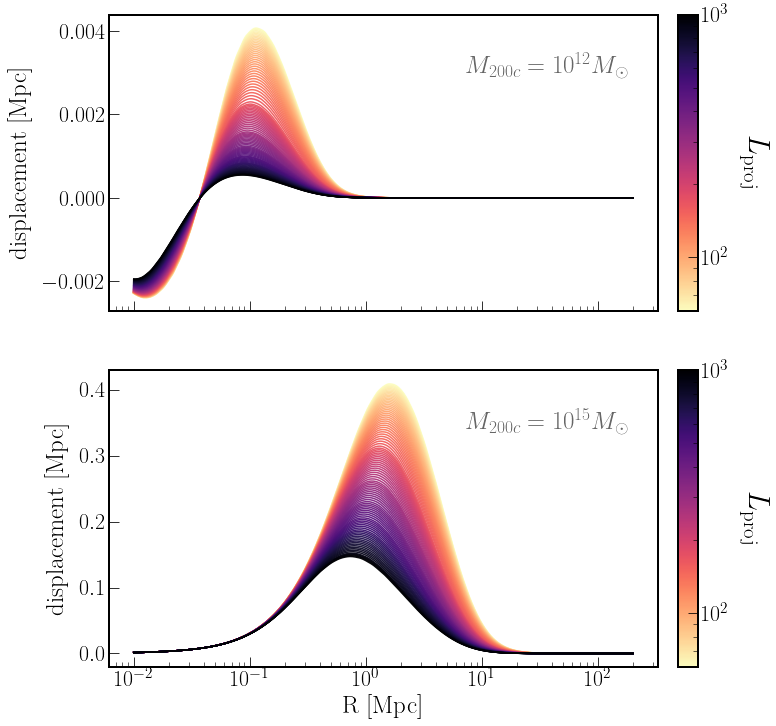

In [5]:
import matplotlib as mpl
fig, ax = plt.subplots(2, 1, figsize = (12, 12), sharex = True)
plt.xscale('log')

M = [1e12, 1e15]

for i in range(len(M)):
    R = np.geomspace(1e-2, 200, 1000)
    a = 1
    for L in np.geomspace(60, 1000, 100):
        ax.flat[i].plot(R, Displacement2D.displacement(R*a, M[i], a, proj_cutoff = L), 
                        color = plt.get_cmap('magma_r')(np.log10(L/60)/np.log10(1000/60)), 
                        rasterized = True, alpha = 0.95)
    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap = 'magma_r', norm = mpl.colors.LogNorm(vmin = 60, vmax = 1000)), 
                        ax = ax.flat[i], aspect = 15, pad = 0.03)
    cbar.set_label(r'$L_{\rm proj}$', rotation = 270, labelpad = 40, size = 30)

[ax.flat[i].text(0.65, 0.8, '$M_{200c} = 10^{%d} M_\odot$' % (np.log10(M[i])), size = 25, color = 'k', 
                alpha = 0.6, transform = ax.flat[i].transAxes) for i in range(2)]    
ax[-1].set_xlabel('R [Mpc]', size = 25)
[ax[i].set_ylabel('displacement [Mpc]', size = 25, labelpad = 10) for i in range(2)]
plt.show()